In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE #for SMOTE -> install package using: conda install -c conda-forge imbalanced-learn 
from scipy import stats, integrate
import matplotlib.pyplot as plt
import ggplot
import scipy
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

import pylab as pl
from itertools import cycle
from sklearn import cross_validation
from sklearn.svm import SVC

features_list = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','class']
dataset1=pd.read_csv("Heart_Disease_Data.csv")


ModuleNotFoundError: No module named 'imblearn'

In [2]:
# SVM requires that each data instance is represented as a vector of real numbers
# If you already have numeric dtypes (int8|16|32|64,float64,boolean) you can convert it to another "numeric" dtype using Pandas .astype() method. Demo: In [90]: df = pd.DataFrame(np.random.randint(10**5,10**7,(5,3)),columns=list('abc'), dtype=np.int64) In [91]: df Out[91]: a b c 0 9059440 9590567 2076918 1 5861102 4566089 1947323 2 6636568 162770 2487991 3 6794572 5236903 5628779 4 470121 4044395 4546794 In [92]: df.dtypes Out[92]: a int64 b int64 c int64 dtype: object In [93]: df['a'] = df['a'].astype(float) In [94]: df.dtypes Out[94]: a float64 b int64 c int64 dtype: object It won't work for object (string) dtypes, that can't be converted to numbers: In [95]: df.loc[1, 'b'] = 'XXXXXX' In [96]: df Out[96]:...
# Just make everything numeric for ease, later we will convert to ordinal/one-hot encoding.
dataset1 = dataset1.convert_objects(convert_numeric=True)
dataset1 = dataset1.astype('float')

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


#### count missing value in terms of colunms #######

In [3]:
#dataset.shape[0] - dataset.count()
print(dataset1.isnull().any())
dataset1 = dataset1.replace('?', np.nan)

age               False
sex               False
cp                False
trestbps          False
chol              False
fbs               False
restecg           False
thalach           False
exang             False
oldpeak           False
slop              False
ca                 True
thal               True
pred_attribute    False
dtype: bool


#### check for duplications

In [4]:
dataset1.duplicated().any()

False

In [5]:
# based on https://pdfs.semanticscholar.org/daa0/f01f96a89fcfc5f41a2da67fb2a8966900ab.pdf 
# we should pick these features:
Genetic_Based_Decision = dataset1[['cp','trestbps', 'restecg', 'thalach', 'ca', 'thal']]

In [6]:
continuous_vars = dataset1[['age', 'restecg', 'chol', 'thalach', 'oldpeak']] 

def checkforoutlier(df):
    outliersnumbers = 0
    for column in df:
        for number in df[column]:
            if number < np.percentile(
                df[column], 25)-(np.percentile(
                df[column], 75)-np.percentile(
                df[column], 25)) or number > np.percentile(
                df[column], 75)+(np.percentile(
                df[column], 75)-np.percentile(
                df[column], 25)):
                    print("outlier: ", number, column)
                    outliersnumbers += 1
    return outliersnumbers, 'outliers. That is', round(float(outliersnumbers)/float(len(df[column]))*100, 0), 'percent of the total list'

print(checkforoutlier(continuous_vars))

# Thalach seems very high, but after research a heartbeat of 202 is possible: 

outlier:  34.0 age
outlier:  29.0 age
outlier:  77.0 age
outlier:  34.0 age
outlier:  76.0 age
outlier:  354.0 chol
outlier:  340.0 chol
outlier:  353.0 chol
outlier:  417.0 chol
outlier:  360.0 chol
outlier:  141.0 chol
outlier:  341.0 chol
outlier:  407.0 chol
outlier:  564.0 chol
outlier:  394.0 chol
outlier:  409.0 chol
outlier:  126.0 chol
outlier:  342.0 chol
outlier:  131.0 chol
outlier:  99.0 thalach
outlier:  97.0 thalach
outlier:  202.0 thalach
outlier:  96.0 thalach
outlier:  88.0 thalach
outlier:  95.0 thalach
outlier:  96.0 thalach
outlier:  71.0 thalach
outlier:  90.0 thalach
outlier:  3.5 oldpeak
outlier:  3.6 oldpeak
outlier:  3.4 oldpeak
outlier:  3.6 oldpeak
outlier:  6.2 oldpeak
outlier:  3.6 oldpeak
outlier:  4.0 oldpeak
outlier:  5.6 oldpeak
outlier:  4.0 oldpeak
outlier:  4.2 oldpeak
outlier:  4.2 oldpeak
outlier:  3.8 oldpeak
outlier:  3.4 oldpeak
outlier:  3.6 oldpeak
outlier:  4.4 oldpeak
outlier:  4.0 oldpeak
outlier:  3.4 oldpeak
(45, 'outliers. That is', 15.

In [7]:
# Two variables are discrete/ordinal: ca (number of major vessels colored by fluoroscopy) and num (diagnosis of heart disease)
# Three can be directly viewed as 1 hot (because binary): 'sex':'male', 'fbs':'fasting blood sugar', 'exang':'exercise induced angina'

# which leaves 4 for one-hot encoding. problem is that the values aren't unique, so have to manually
# make extra columns:

dataset1["cp"] = dataset1["cp"].replace([1,2,3,4], ["typical angina", "atypical angina", "non-angina", "asymptomatic angina"])
dataset1["restecg"] = dataset1["restecg"].replace([0,1,2], ["normalresecg", "ST-T wave abnormality", "left ventricular hypertrophy"])
dataset1["slop"] = dataset1["slop"].replace([1,2,3], ["upsloping", "flat", "downsloping"])
dataset1["thal"] = dataset1["thal"].replace([3,6,7], ["normalthal", "fixed defect", "reversible defect"])

x = dataset1[['cp', 'restecg', 'slop', 'thal']]
for column in ['cp', 'restecg', 'slop', 'thal']:
    one_hot = pd.get_dummies(dataset1[column])
    dataset1 = dataset1.drop(column, axis=1)
    dataset1 = dataset1.join(one_hot)

In [8]:
### Extract features and labels from dataset for local testing:
dataset1.dropna(inplace=True, axis=0, how="any")
Y=dataset1["pred_attribute"]
dataset1 = dataset1.drop("pred_attribute", axis=1)
X=dataset1

In [9]:
# evaluate the model by splitting into train and test sets  #Edit by ryan, we aim to do 3 traditional sets in the end, this first split is 80/20
features_train, features_test, labels_train, labels_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [10]:
import collections

list1 = []
for i in labels_train:
    list1.append(i)
counter=collections.Counter(list1)
print(counter)

list2 = []
for i in labels_test:
    list2.append(i)
counter=collections.Counter(list2)
print(counter)

Counter({0.0: 131, 1.0: 42, 3.0: 32, 2.0: 26, 4.0: 8})
Counter({0.0: 30, 1.0: 12, 2.0: 10, 4.0: 5, 3.0: 3})


In [11]:
# Check
print(len(features_train)/(len(features_train)+ len(features_test)))

0.7993311036789298


In [12]:
features_train_df = pd.DataFrame(features_train)
features_train_df.to_csv('features_train.csv', index=False)

features_test_df = pd.DataFrame(features_test)
features_test_df.to_csv('features_test.csv', index=False)

labels_train_df = pd.DataFrame(labels_train)
labels_train_df.to_csv('labels_train.csv', index=False)

labels_test_df = pd.DataFrame(labels_test)
labels_test_df.to_csv('labels_test.csv', index=False)

## Feature Importance Scores based on XGBoost (by David)

In [13]:
import xgboost as xgb
import operator

xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'lambda': 0.8,   
    'alpha': 0.4,
    'silent': 1,
    'num_class': 5
}

dtrain = xgb.DMatrix(features_train, labels_train)
dtest = xgb.DMatrix(features_test, labels_test)

num_boost_rounds = 250

watchlist = [(dtrain, 'train'), (dtest, 'test')]

# train model
xgb_model = xgb.train(xgb_params, dtrain, num_boost_rounds, watchlist)

[0]	train-mlogloss:1.56662	test-mlogloss:1.58393
[1]	train-mlogloss:1.52295	test-mlogloss:1.55394
[2]	train-mlogloss:1.48109	test-mlogloss:1.52955
[3]	train-mlogloss:1.4421	test-mlogloss:1.50704
[4]	train-mlogloss:1.4071	test-mlogloss:1.48778
[5]	train-mlogloss:1.37186	test-mlogloss:1.46671
[6]	train-mlogloss:1.33841	test-mlogloss:1.4476
[7]	train-mlogloss:1.30748	test-mlogloss:1.43219
[8]	train-mlogloss:1.27943	test-mlogloss:1.41783
[9]	train-mlogloss:1.24884	test-mlogloss:1.40222
[10]	train-mlogloss:1.22033	test-mlogloss:1.38607
[11]	train-mlogloss:1.19511	test-mlogloss:1.37279
[12]	train-mlogloss:1.16805	test-mlogloss:1.36199
[13]	train-mlogloss:1.14312	test-mlogloss:1.35062
[14]	train-mlogloss:1.11934	test-mlogloss:1.34054
[15]	train-mlogloss:1.09597	test-mlogloss:1.33341
[16]	train-mlogloss:1.07423	test-mlogloss:1.32293
[17]	train-mlogloss:1.05318	test-mlogloss:1.31409
[18]	train-mlogloss:1.03206	test-mlogloss:1.30246
[19]	train-mlogloss:1.0118	test-mlogloss:1.29283
[20]	train-mlo

[161]	train-mlogloss:0.222303	test-mlogloss:1.28751
[162]	train-mlogloss:0.220927	test-mlogloss:1.28899
[163]	train-mlogloss:0.219704	test-mlogloss:1.29039
[164]	train-mlogloss:0.218196	test-mlogloss:1.29284
[165]	train-mlogloss:0.216814	test-mlogloss:1.29336
[166]	train-mlogloss:0.215436	test-mlogloss:1.29504
[167]	train-mlogloss:0.214174	test-mlogloss:1.29697
[168]	train-mlogloss:0.212971	test-mlogloss:1.298
[169]	train-mlogloss:0.211838	test-mlogloss:1.30063
[170]	train-mlogloss:0.210456	test-mlogloss:1.30228
[171]	train-mlogloss:0.209322	test-mlogloss:1.3043
[172]	train-mlogloss:0.208049	test-mlogloss:1.3049
[173]	train-mlogloss:0.207018	test-mlogloss:1.30641
[174]	train-mlogloss:0.205864	test-mlogloss:1.30875
[175]	train-mlogloss:0.204727	test-mlogloss:1.31047
[176]	train-mlogloss:0.20352	test-mlogloss:1.31055
[177]	train-mlogloss:0.202312	test-mlogloss:1.31109
[178]	train-mlogloss:0.201124	test-mlogloss:1.31253
[179]	train-mlogloss:0.200133	test-mlogloss:1.31433
[180]	train-mlogl

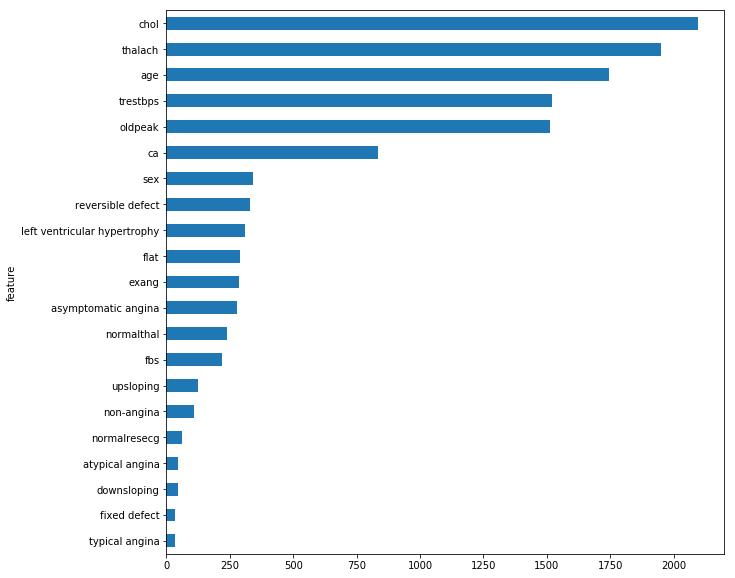

In [14]:
importance = xgb_model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])

# Plot Feature Importance
plt.figure()
importance_df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 10))

In [15]:
def feature_selection(dataframe, importance_scores_df, threshold=0.4):
    normalized_df = importance_scores_df.copy()
    normalized_df['fscore'] = (importance_scores_df['fscore'] - importance_scores_df['fscore'].min())/(importance_scores_df['fscore'].max()-importance_scores_df['fscore'].min())
    normalized_df = normalized_df[normalized_df['fscore'] >= threshold]
    new_dataframe = dataframe.filter(items=normalized_df['feature'].tolist())
    return new_dataframe

features_train_009_df = feature_selection(features_train_df, importance_df, threshold=0.09)
features_train_009 = features_train_009_df.as_matrix()
features_train_04_df = feature_selection(features_train_df, importance_df, threshold=0.4)
features_train_04 = features_train_04_df.as_matrix()

features_test_009_df = feature_selection(features_test_df, importance_df, threshold=0.09)
features_test_009 = features_test_009_df.as_matrix()
features_test_04_df = feature_selection(features_test_df, importance_df, threshold=0.4)
features_test_04 = features_test_04_df.as_matrix()

## Principal Component Analysis (by David)

In [36]:
from numpy import linalg as LA

def eigen_scores(dataframe):
    dataframe-=np.mean(dataframe, axis=0)
    dataframe/=np.std(dataframe, axis=0)
    cov_mat=np.cov(dataframe, rowvar=False)
    evals, evecs = np.linalg.eigh(cov_mat)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    return evals, evecs

def my_pca(dataframe, n_components):
    pca=PCA(n_components=n_components)
    return pca.fit_transform(dataframe)
    
eigenvalues, eigenvectors = eigen_scores(features_test_04.copy())
n_components_04 = len(np.where(eigenvalues >= 1)[0])
print("Number of components for Dataset with threshold=0.4 is {}".format(n_components_04))

features_train_04_pca = my_pca(features_train_04, n_components_04)
features_test_04_pca = my_pca(features_test_04, n_components_04)

eigenvalues, eigenvectors = eigen_scores(features_test_009.copy())
n_components_009 = len(np.where(eigenvalues >= 1)[0])
print("Number of components for Dataset with threshold=0.09 is {}".format(n_components_009))

features_train_009_pca = my_pca(features_train_009, n_components_009)
features_test_009_pca = my_pca(features_test_009, n_components_009)

Number of components for Dataset with threshold=0.4 is 2
Number of components for Dataset with threshold=0.09 is 5


## Dataset Splitting

We have an relatively small dataset. Therefore, we should do our feature selection based on a cross-
validated set. We will check this assumption by comparing the scores on a cross-validated set vs the simple split.

In [ ]:
features_train_cross, features_test_cross, labels_train_cross, labels_test_cross = train_test_split(X, Y, test_size=0.2, random_state=0)

### SMOTE for SVM - Balancing only on the training set, not the validation set  [This is for the traditional training -not the cross validated one]

In [ ]:
#further divide the 'traditional' non-cross set into training 80/20  for pure training and cross validation  
features_train_notoversampled, features_validate, labels_train_notoversampled, labels_validate = train_test_split(features_train, labels_train, test_size = .2, random_state=0)

sm = SMOTE(random_state=0, ratio = 1.0, kind= 'svm' )
#x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
features_train_oversampled, labels_train_oversampled = sm.fit_sample(features_train_notoversampled, labels_train_notoversampled)

#re-enter into original variables
##features_train = features_train_oversampled
##labels_train = labels_train_oversampled

#Below 2 lines if we want to want to force the array back into dataframe    
##features_train = pd.DataFrame(features_train_oversampled,columns=["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slop","ca","thal"])
##labels_train = pd.DataFrame(labels_train_oversampled,columns=["pred_attribute"])

## Standard Scaler (by David)
SVC Models are only any good when the data is scaled. Lets scale the data and build the model

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

scaler = MinMaxScaler()
Standard_scaler = StandardScaler()
Robust_scaler = preprocessing.RobustScaler(quantile_range=(25, 75))
Quantile_scalar = preprocessing.QuantileTransformer(output_distribution='normal')

features_train = Standard_scaler.fit_transform(features_train)
features_test = Standard_scaler.transform(features_test)

features_train_009 = Standard_scaler.fit_transform(features_train_009)
features_test_009 = Standard_scaler.transform(features_test_009)

features_train_04 = Standard_scaler.fit_transform(features_train_04)
features_test_04 = Standard_scaler.transform(features_test_04)

features_train_009_pca = Standard_scaler.fit_transform(features_train_009_pca)
features_test_009_pca = Standard_scaler.transform(features_test_009_pca)

features_train_04_pca = Standard_scaler.fit_transform(features_train_04_pca)
features_test_04_pca = Standard_scaler.transform(features_test_04_pca)

features_train

array([[-1.19127179, -1.39664501, -0.55805859, ..., -0.21964884,
         0.91567545, -0.81934649],
       [-0.75808205,  0.71600156, -1.32901815, ..., -0.21964884,
         0.91567545, -0.81934649],
       [ 0.        , -1.39664501,  0.15783243, ..., -0.21964884,
         0.91567545, -0.81934649],
       ...,
       [-2.05765127, -1.39664501,  0.32303804, ..., -0.21964884,
         0.91567545, -0.81934649],
       [-0.43318974,  0.71600156,  0.98386052, ..., -0.21964884,
        -1.09208999,  1.22048488],
       [ 0.86637948, -1.39664501,  0.43317512, ..., -0.21964884,
         0.91567545, -0.81934649]])

### Modified by David

In [18]:
from sklearn.metrics import accuracy_score
from sklearn import grid_search
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error
import seaborn as sns

def checkmetrics(pred, labels_test, name):
    sns.set()
    print('The accuracy of ', name, 'is: ', accuracy_score(pred, labels_test))
    matrix = confusion_matrix(labels_test, pred)
    ax = sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    print(ax)
    print(classification_report(pred, labels_test))

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Feature selection?

In [19]:
# Feature selection using RFECV to pick best features,
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFECV
rlasso = RandomizedLasso(alpha=0.025)
names = features_list
rlasso.fit(features_train, labels_train)
 
print("Features sorted by their score using lasso:")
print(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 names), reverse=True))

#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,Y)
 
print("Features sorted by their score using Linear Regression:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))

Features sorted by their score using lasso:
[(0.485, 'oldpeak'), (0.485, 'exang'), (0.475, 'thalach'), (0.405, 'fbs'), (0.24, 'restecg'), (0.005, 'age'), (0.0, 'trestbps'), (0.0, 'thal'), (0.0, 'slope'), (0.0, 'sex'), (0.0, 'cp'), (0.0, 'class'), (0.0, 'chol'), (0.0, 'ca')]
Features sorted by their score using Linear Regression:
[(1, 'class'), (3, 'oldpeak'), (5, 'exang'), (7, 'restecg'), (8, 'sex'), (9, 'thal'), (10, 'thalach'), (12, 'ca'), (17, 'slope'), (18, 'chol'), (19, 'cp'), (20, 'age'), (21, 'fbs'), (22, 'trestbps')]


/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


## Linear kernel

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score: 0.7280334728033473 with parameters: {'C': 0.2, 'class_weight': None, 'gamma': 1e-05}
The accuracy of  No SMOTE - sq hinge - Validate - support vector machine linear is:  0.5333333333333333
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.93      0.70      0.80        40
        1.0       0.08      0.17      0.11         6
        2.0       0.20      0.25      0.22         8
        3.0       0.33      0.17      0.22         6
        4.0       0.00      0.00      0.00         0

avg / total       0.69      0.53      0.60        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


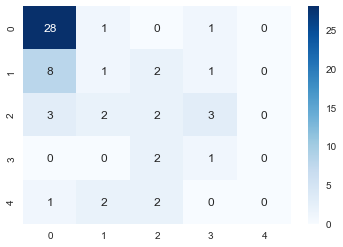

In [20]:
parameters ={
    'C': [0.1,0.2,0.5,1,2,3,4,5], 
    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5],
    "class_weight": ['balanced', None]
}
SVM = svm.SVC(kernel="linear")
grid_search_cv = GridSearchCV(SVM, parameters, cv=10)
grid_search_cv.fit(features_train, labels_train)

print("The train score:", str(grid_search_cv.score(features_train, labels_train)), "with parameters:", grid_search_cv.best_params_)

pred = grid_search_cv.predict(features_test)
checkmetrics(pred, labels_test, 'No SMOTE - sq hinge - Validate - support vector machine linear')

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score for ovo: 0.7280334728033473 with parameters: {'C': 0.2, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 1e-05}
The accuracy of  No SMOTE - sq hinge, one vs one - Validate - support vector machine linear is:  0.5333333333333333
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.93      0.70      0.80        40
        1.0       0.08      0.17      0.11         6
        2.0       0.20      0.25      0.22         8
        3.0       0.33      0.17      0.22         6
        4.0       0.00      0.00      0.00         0

avg / total       0.69      0.53      0.60        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


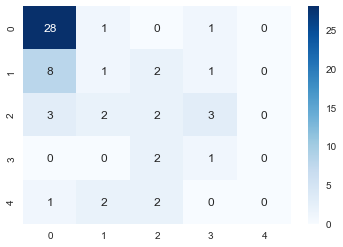

In [21]:
# Compare with one-versus all:
parameters ={
    'C': [0.1,0.2,0.5,1,2,3,4,5],
    "class_weight": ['balanced', None],
    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5], 
             'decision_function_shape': ['ovo', 'ovr']
}
SVM = svm.SVC(kernel="linear")
grid_search_cv = GridSearchCV(SVM, parameters, cv=10)
grid_search_cv.fit(features_train, labels_train)

print("The train score for ovo:", str(grid_search_cv.score(features_train, labels_train)), 'with parameters:', grid_search_cv.best_params_)
pred = grid_search_cv.predict(features_test)
checkmetrics(pred, labels_test, 'No SMOTE - sq hinge, one vs one - Validate - support vector machine linear')

Try different model (standard one vs. rest) loss not automatically being squared hinge:

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score:  0.6820083682008368 with parameters: {'C': 1, 'class_weight': None}
The accuracy of  No SMOTE - hinge - Validate - support vector machine linear is:  0.55
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.93      0.70      0.80        40
        1.0       0.08      0.25      0.12         4
        2.0       0.10      0.50      0.17         2
        3.0       0.67      0.17      0.27        12
        4.0       0.20      0.50      0.29         2

avg / total       0.77      0.55      0.61        60



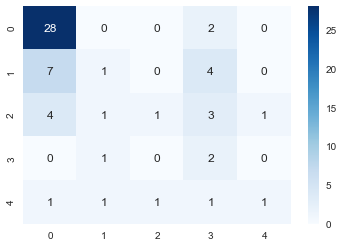

In [22]:
parameters = {
    'C': [0.1,0.2,0.5,1,2,3,4,5],
    "class_weight": ['balanced', None]
}
SVM = LinearSVC(loss="hinge")
grid_search = GridSearchCV(SVM, parameters, cv=10)
grid_search.fit(features_train, labels_train)

print("The train score: ", str(grid_search.score(features_train, labels_train)), 'with parameters:', grid_search.best_params_)

pred = grid_search.predict(features_test)
checkmetrics(pred, labels_test, 'No SMOTE - hinge - Validate - support vector machine linear')

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score:  0.7112970711297071 with parameters: {'C': 0.2, 'class_weight': None, 'multi_class': 'crammer_singer'}
The accuracy of  No SMOTE - hinge, one vs rest - Validate - support vector machine linear is:  0.55
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.93      0.72      0.81        39
        1.0       0.08      0.17      0.11         6
        2.0       0.20      0.40      0.27         5
        3.0       0.67      0.20      0.31        10
        4.0       0.00      0.00      0.00         0

avg / total       0.74      0.55      0.61        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


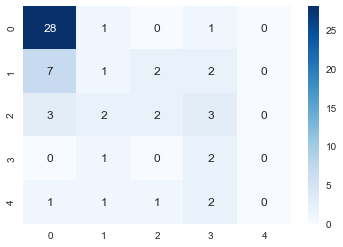

In [23]:
# Compare with Cramer:
parameters = {
    'C': [0.1,0.2,0.5,1,2,3,4,5],
    "class_weight": ['balanced', None],
    'multi_class':['ovr', 'crammer_singer']
}
SVM = LinearSVC(loss="hinge")
grid_search = GridSearchCV(SVM, parameters, cv=10)
grid_search.fit(features_train, labels_train)

print("The train score: ", str(grid_search.score(features_train, labels_train)), 'with parameters:', grid_search.best_params_)

pred = grid_search.predict(features_test)
checkmetrics(pred, labels_test, 'No SMOTE - hinge, one vs rest - Validate - support vector machine linear')

## Nonlinear SVM Classification
### Polynominal features

Note that when there are multiple features, Polynomial Regression is capable of finding relationships
between features (which is something a plain Linear Regression model cannot do). This is made possible
by the fact that PolynomialFeatures also adds all combinations of features up to the given degree. 

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score: 0.6820083682008368 with parameters: {'C': 3, 'coef0': 1, 'degree': 1, 'gamma': 0.01}
The accuracy of  No SMOTE - sq hinge - Validate - support vector machine linear is:  0.5
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.93      0.70      0.80        40
        1.0       0.08      0.20      0.12         5
        2.0       0.10      0.17      0.12         6
        3.0       0.00      0.00      0.00         9
        4.0       0.00      0.00      0.00         0

avg / total       0.64      0.50      0.56        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


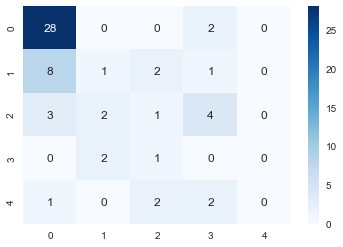

In [24]:
# HOW GRIDSEARCH SHOULD WORK
parameters = {
    'C': [0.1,0.2,0.5,1,2,3,4,5], 
    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5],
    "degree": [1,2,3],
    "coef0": [1,10]
}
SVM = svm.SVC(kernel="poly")
grid_search = GridSearchCV(SVM, parameters, cv=10)
grid_search.fit(features_train, labels_train)

print("The train score:", str(grid_search.score(features_train, labels_train)), "with parameters:", grid_search.best_params_)

pred = grid_search.predict(features_test)
checkmetrics(pred, labels_test, 'No SMOTE - sq hinge - Validate - support vector machine linear')

### RBF Kernel

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score: 0.698744769874477 with parameters: {'C': 2, 'class_weight': None, 'gamma': 0.01}
The accuracy of  No SMOTE - sq hinge - Validate - support vector machine linear is:  0.5
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.90      0.66      0.76        41
        1.0       0.08      0.33      0.13         3
        2.0       0.10      0.25      0.14         4
        3.0       0.33      0.08      0.13        12
        4.0       0.00      0.00      0.00         0

avg / total       0.69      0.50      0.56        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


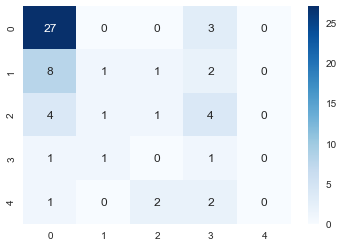

In [25]:
# Just like the polynomial features method, the similarity features method can be useful with any Machine
# Learning algorithm, but it may be computationally expensive to compute all the additional features,
# especially on large training sets. However, once again the kernel trick does its SVM magic: it makes it
# possible to obtain a similar result as if you had added many similarity features, without actually having to
# add them

parameters ={
    'C': [0.1,0.2,0.5,1,2,3,4,5], 
    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5],         
    "class_weight": ['balanced', None]
}
SVM = svm.SVC(kernel="rbf")
grid_search = GridSearchCV(SVM, parameters, cv=10)
grid_search.fit(features_train, labels_train)

print("The train score:", str(grid_search.score(features_train, labels_train)), "with parameters:", grid_search.best_params_)

pred = grid_search.predict(features_test)
checkmetrics(pred, labels_test, 'No SMOTE - sq hinge - Validate - support vector machine linear')

# no need to compare with one vs all

## Using Important Features with threshold >= 0.09 (by David)

### RBF Kernel

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score: 0.6861924686192469 with parameters: {'C': 0.5, 'class_weight': None, 'gamma': 0.05}
The accuracy of  No SMOTE - sq hinge - Validate - support vector machine linear is:  0.48333333333333334
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.93      0.65      0.77        43
        1.0       0.00      0.00      0.00         4
        2.0       0.00      0.00      0.00         0
        3.0       0.33      0.08      0.12        13
        4.0       0.00      0.00      0.00         0

avg / total       0.74      0.48      0.58        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


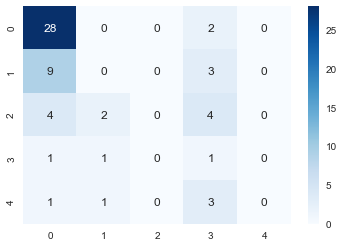

In [26]:
# Just like the polynomial features method, the similarity features method can be useful with any Machine
# Learning algorithm, but it may be computationally expensive to compute all the additional features,
# especially on large training sets. However, once again the kernel trick does its SVM magic: it makes it
# possible to obtain a similar result as if you had added many similarity features, without actually having to
# add them

parameters ={
    'C': [0.1,0.2,0.5,1,2,3,4,5], 
    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5],         
    "class_weight": ['balanced', None]
}
SVM = svm.SVC(kernel="rbf")
grid_search = GridSearchCV(SVM, parameters, cv=10)
grid_search.fit(features_train_009, labels_train)

print("The train score:", str(grid_search.score(features_train_009, labels_train)), "with parameters:", grid_search.best_params_)

pred = grid_search.predict(features_test_009)
checkmetrics(pred, labels_test, 'No SMOTE - sq hinge - Validate - support vector machine linear')

# no need to compare with one vs all

## Using Important Features with threshold >= 0.4 (by David)

### RBF Kernel

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score: 0.7489539748953975 with parameters: {'C': 2, 'class_weight': None, 'gamma': 0.2}
The accuracy of  No SMOTE - sq hinge - Validate - support vector machine linear is:  0.5
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.93      0.60      0.73        47
        1.0       0.00      0.00      0.00         0
        2.0       0.10      0.20      0.13         5
        3.0       0.33      0.12      0.18         8
        4.0       0.00      0.00      0.00         0

avg / total       0.78      0.50      0.61        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


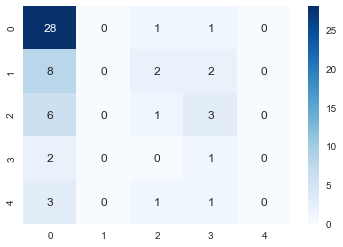

In [27]:
# Just like the polynomial features method, the similarity features method can be useful with any Machine
# Learning algorithm, but it may be computationally expensive to compute all the additional features,
# especially on large training sets. However, once again the kernel trick does its SVM magic: it makes it
# possible to obtain a similar result as if you had added many similarity features, without actually having to
# add them

parameters ={
    'C': [0.1,0.2,0.5,1,2,3,4,5], 
    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5],         
    "class_weight": ['balanced', None]
}
SVM = svm.SVC(kernel="rbf")
grid_search = GridSearchCV(SVM, parameters, cv=10)
grid_search.fit(features_train_04, labels_train)

print("The train score:", str(grid_search.score(features_train_04, labels_train)), "with parameters:", grid_search.best_params_)

pred = grid_search.predict(features_test_04)
checkmetrics(pred, labels_test, 'No SMOTE - sq hinge - Validate - support vector machine linear')

# no need to compare with one vs all

## Using PCA with Important Features (threshold >= 0.09) by David

### RBF Kernel

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score: 0.6569037656903766 with parameters: {'C': 5, 'class_weight': None, 'gamma': 0.01}
The accuracy of  No SMOTE - sq hinge - Validate - support vector machine linear is:  0.5333333333333333
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.93      0.68      0.79        41
        1.0       0.08      0.20      0.12         5
        2.0       0.10      0.50      0.17         2
        3.0       0.67      0.17      0.27        12
        4.0       0.00      0.00      0.00         0

avg / total       0.78      0.53      0.61        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


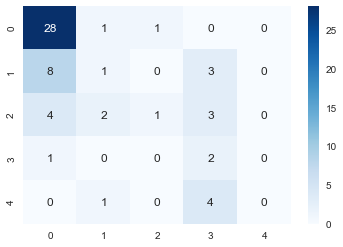

In [45]:
# Just like the polynomial features method, the similarity features method can be useful with any Machine
# Learning algorithm, but it may be computationally expensive to compute all the additional features,
# especially on large training sets. However, once again the kernel trick does its SVM magic: it makes it
# possible to obtain a similar result as if you had added many similarity features, without actually having to
# add them

parameters ={
    'C': [0.1,0.2,0.5,1,2,3,4,5], 
    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5],         
    "class_weight": ['balanced', None]
}
SVM = svm.SVC(kernel="rbf")
grid_search = GridSearchCV(SVM, parameters, cv=10)
grid_search.fit(features_train_009_pca, labels_train)

print("The train score:", str(grid_search.score(features_train_009_pca, labels_train)), "with parameters:", grid_search.best_params_)

pred = grid_search.predict(features_test_009_pca)
checkmetrics(pred, labels_test, 'No SMOTE - sq hinge - Validate - support vector machine linear')

# no need to compare with one vs all

## Using PCA with Important Features (threshold >= 0.4) by David

### RBF Kernel

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


The train score: 0.6485355648535565 with parameters: {'C': 4, 'class_weight': None, 'gamma': 1}
The accuracy of  No SMOTE - sq hinge - Validate - support vector machine linear is:  0.35
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.70      0.42      0.53        50
        1.0       0.00      0.00      0.00         6
        2.0       0.00      0.00      0.00         3
        3.0       0.00      0.00      0.00         1
        4.0       0.00      0.00      0.00         0

avg / total       0.58      0.35      0.44        60



/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


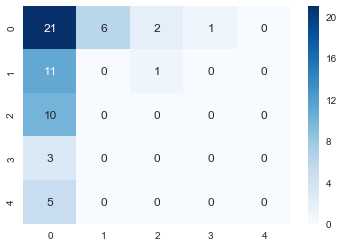

In [47]:
# Just like the polynomial features method, the similarity features method can be useful with any Machine
# Learning algorithm, but it may be computationally expensive to compute all the additional features,
# especially on large training sets. However, once again the kernel trick does its SVM magic: it makes it
# possible to obtain a similar result as if you had added many similarity features, without actually having to
# add them

parameters ={
    'C': [0.1,0.2,0.5,1,2,3,4,5], 
    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5],         
    "class_weight": ['balanced', None]
}
SVM = svm.SVC(kernel="rbf")
grid_search = GridSearchCV(SVM, parameters, cv=10)
grid_search.fit(features_train_04_pca, labels_train)

print("The train score:", str(grid_search.score(features_train_04_pca, labels_train)), "with parameters:", grid_search.best_params_)

pred = grid_search.predict(features_test_04_pca)
checkmetrics(pred, labels_test, 'No SMOTE - sq hinge - Validate - support vector machine linear')

# no need to compare with one vs all